In [1]:
from glob import glob
import numpy as np
from evFileProcessing import evFuncs # ev COM functions
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib.lines import Line2D
import datetime
from pysolar.solar import *
warnings.filterwarnings('ignore')

C11 = 70.0136, -166.85755
C1 = 70.8357, -163.1044
C4 = 71.038916, -160.50353

def addAlt(d,site):
    date = datetime.datetime(d.year, d.month, d.day, d.hour, d.minute, tzinfo=datetime.timezone.utc)
    return get_altitude(site[0],site[1],date)

def wakeupMWD(df):
    df = df.rename(columns={'datetime':'dt'})
    binCenters = np.arange(2.5,5*df.layer.unique().max(),1)
    depth = []
    #print('appending bin centers...')
    for layer in df.layer:
        depth.append(binCenters[int(layer)-1])
    df['depthBin'] = depth
    df['weightedSA'] = df.sA*df.depthBin
    df = df.groupby(['dt'])[["sA", "weightedSA"]].sum()
    df['mwd'] = df.weightedSA/df.sA
    df = df.reset_index()
    df['solAlt'] = df['dt'].apply(addAlt, site=C11)
    df.set_index('dt')
    df = df.set_index('dt')
    df = df.drop(columns=['weightedSA'])
    return df

def solMinMax(df):
    a = df[df.index.isin(df.groupby(df.index.date)["solAlt"].idxmax())].solAlt<=0
    df = pd.DataFrame({'dt':df[df.index.isin(df.groupby(df.index.date)["solAlt"].idxmax())].index,'day':df[df.index.isin(df.groupby(df.index.date)["solAlt"].idxmax())].mwd.values,'night':df[df.index.isin(df.groupby(df.index.date)["solAlt"].idxmin())].mwd.values,'pNight':a.values})
    df =df.set_index('dt')
    #df.loc[(df.pNight==True),'day'] = 0
    #df.loc[(df.pNight==True),'night'] = 0
    return df

def sunlight(s):
    t = pd.DataFrame({'dt':pd.date_range(start='2017-8-5', end='2019-9-7',freq='.1H'),'solAlt':0})
    t['solAlt'] = t['dt'].apply(addAlt, site=s)
    t['s'] = 0
    t.loc[(t.solAlt>0),'s'] = 1
    t = t.set_index('dt')
    t = t.resample('1D').sum().drop(columns=['solAlt'])
    t['s'] = t.s/(24/.1)
    return t

def readCTD(file):
    df = pd.read_csv(file)
    df = df[df.Sal > 20]
    df['dt'] = pd.to_datetime(df['Date']+df['Time'])
    df = df.set_index('dt')
    return df

def readTracks(file):
    dfTracks = pd.read_csv(file)
    dfTracks['Date_S'] = dfTracks['Date_S'].astype(str)
    dfTracks['Datetime'] = pd.to_datetime(dfTracks['Date_S'] + ' ' + dfTracks['Time_S'])
    dfTracks = dfTracks.drop(['Date_S','Time_S'], axis=1)
    dfTracks = dfTracks.set_index('Datetime')
    return dfTracks

In [2]:
# Moorings
filesD1Y1 = glob('../data/2018/EVFiles/DAFT1/exports/1m/70*.csv')
filesD1Y2 = glob('../data/2019/EVFiles/DAFT1/exports/1m/70*.csv')
dfD1 = evFuncs.evExports.readEvExports(filesD1Y1+filesD1Y2)
dfD1 = wakeupMWD(dfD1)
dfD1.name = 'D1'
dfD1_DayNight = solMinMax(dfD1)

filesD2Y1 = glob('../data/2018/EVFiles/DAFT2/exports/1m/70*.csv')
filesD2Y2 = glob('../data/2019/EVFiles/DAFT2/exports/1m/70*.csv')
dfD2 = evFuncs.evExports.readEvExports(filesD2Y1+filesD2Y2)
dfD2 = wakeupMWD(dfD2)
dfD2.name = 'D2'
dfD2_DayNight = solMinMax(dfD2)


filesD3Y2 = glob('../data/2019/EVFiles/DAFT3/exports/1m/70*.csv')
dfD3 = evFuncs.evExports.readEvExports(filesD3Y2)
dfD3 = wakeupMWD(dfD3)
dfD3.name = 'D3'
dfD3_DayNight = solMinMax(dfD3)

dfD1_sunlight = sunlight(C11)
dfD2_sunlight = sunlight(C1)
dfD3_sunlight = sunlight(C4)

In [3]:
# Tracks
df1 = readTracks('../data/analysisFiles/TrackRegions1_linear3.csv')
df4 = readTracks('../data/analysisFiles/TrackRegions4_linear3.csv')
dfD1T = pd.concat([df1,df4])
df2 = readTracks('../data/analysisFiles/TrackRegions2_linear3.csv')
df5 = readTracks('../data/analysisFiles/TrackRegions5_linear3.csv')
dfD2T = pd.concat([df2,df5])
dfD3T = readTracks('../data/analysisFiles/TrackRegions6_linear3.csv')

In [4]:
# CTD
dfCTD1 =readCTD(glob('../data/2018/DAFT1/SBE37/*.csv')[0])
dfCTD4 =readCTD(glob('../data/2019/DAFT1/SBE37/*.csv')[0])
dfD1Ctd = pd.concat([dfCTD1, dfCTD4])
dfCTD2 =readCTD(glob('../data/2018/DAFT2/SBE37/*.csv')[0])
dfCTD5 =readCTD(glob('../data/2019/DAFT2/SBE37/*.csv')[0])
dfD2Ctd = pd.concat([dfCTD2, dfCTD5])
dfD3Ctd =readCTD(glob('../data/2019/DAFT3/SBE37/*.csv')[0])

# Ice
dfD1Ice = pd.read_csv('../data/physicalData/C11_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')
dfD2Ice = pd.read_csv('../data/physicalData/C1_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')
dfD3Ice = pd.read_csv('../data/physicalData/C4_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')

9.37788018900322

9.37788018900322


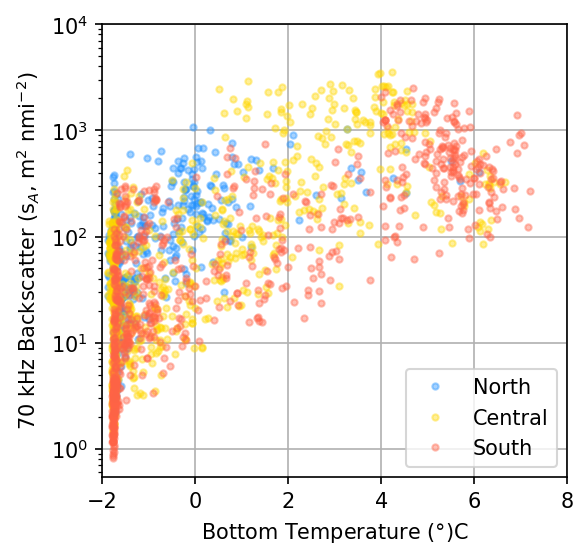

In [20]:
all = []
fig = plt.figure(figsize=(4,4),dpi=150)
df = dfD3
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD3Ctd
a = df.resample('D').mean()
c = a.join(b)
all.append(c)
plt.semilogy(c.Temp,c.sA,'.',color='dodgerblue',alpha=0.4)


df = dfD2
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD2Ctd
a = df.resample('D').mean()
c = a.join(b)
plt.semilogy(c.Temp,(c.sA),'.',color='gold',alpha=0.4)
all.append(c)


df = dfD1
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD1Ctd
a = df.resample('D').mean()
c = a.join(b)
plt.semilogy(c.Temp,(c.sA),'.',color='tomato',alpha=0.4)
all.append(c)

plt.axis([-2,8,0,10**4])
plt.grid()
plt.xlabel('Bottom Temperature ($\degree$)C')
plt.ylabel('70 kHz Backscatter (s$_{A}$, m$^{2}$ nmi$^{-2}$)')
plt.legend(['North','Central','South'],loc='lower right')

z = pd.concat(all)
print(z[z.Temp>0].sA.mean()/z[z.Temp<0].sA.mean())

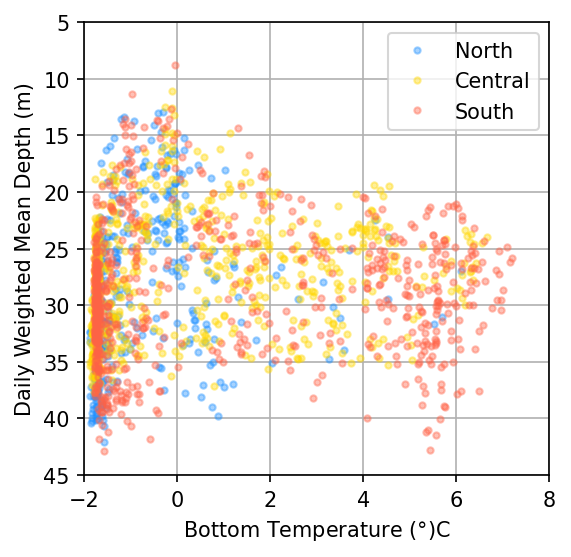

In [38]:
fig = plt.figure(figsize=(4,4),dpi=150)
df = dfD3
b = df['mwd'].resample('D').mean()
df = dfD3Ctd
a = df.resample('D').mean()
c = a.join(b)
plt.plot(c.Temp,c.mwd,'.',color='dodgerblue',alpha=0.4)


df = dfD2
b = df['mwd'].resample('D').mean()
df = dfD2Ctd
a = df.resample('D').mean()
c = a.join(b)
plt.plot(c.Temp,(c.mwd),'.',color='gold',alpha=0.4)


df = dfD1
b = df['mwd'].resample('D').mean()
df = dfD1Ctd
a = df.resample('D').mean()
c = a.join(b)
plt.plot(c.Temp,(c.mwd),'.',color='tomato',alpha=0.4)

plt.axis([-2,8,5,45])
plt.grid()
plt.gca().invert_yaxis()
plt.xlabel('Bottom Temperature ($\degree$)C')
plt.ylabel('Daily Weighted Mean Depth (m)')
plt.legend(['North','Central','South'],loc='upper right')

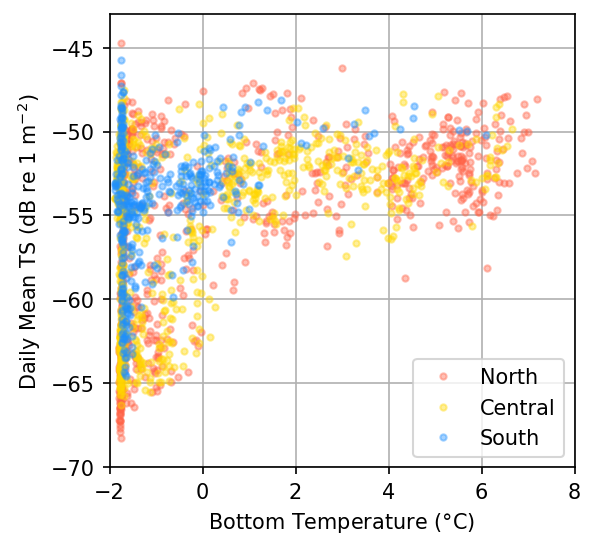

In [43]:
fig = plt.figure(figsize=(4,4),dpi=150)
df = dfD1T
b = 10**(df['TS_mean']/10).resample('D').mean()
df = dfD1Ctd
a = df.resample('D').mean()
c = a.join(b)
plt.plot(c.Temp,10*np.log10(c.TS_mean),'.',color='tomato',alpha=0.4)

df = dfD2T
b = 10**(df['TS_mean']/10).resample('D').mean()
df = dfD2Ctd
a = df.resample('D').mean()
c = a.join(b)
plt.plot(c.Temp,10*np.log10(c.TS_mean),'.',color='gold',alpha=0.4)

df = dfD3T
b = 10**(df['TS_mean']/10).resample('D').mean()
df = dfD3Ctd
a = df.resample('D').mean()
c = a.join(b)
plt.plot(c.Temp,10*np.log10(c.TS_mean),'.',color='dodgerblue',alpha=0.4)

plt.axis([-2,8,-70,-43])
plt.grid()
plt.xlabel('Bottom Temperature ($\degree$C)')
plt.ylabel('Daily Mean TS (dB re 1 m$^{-2}$)')
plt.legend(['North','Central','South'],loc='lower right')

In [ ]:
fig = plt.figure(figsize=(4,4),dpi=150)
df = dfD3
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD1Ice
a = df.resample('D').mean()
c = a.join(b)
plt.semilogy(c.iceC*100,c.sA,'.',color='dodgerblue',alpha=0.4)


df = dfD2
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD2Ice
a = df.resample('D').mean()
c = a.join(b)
plt.semilogy(c.iceC*100,(c.sA),'.',color='gold',alpha=0.4)


df = dfD1
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD3Ice
a = df.resample('D').mean()
c = a.join(b)
plt.semilogy(c.iceC*100,(c.sA),'.',color='tomato',alpha=0.4)

plt.axis([-2,102,0,10**4])
plt.grid()
plt.xlabel('Sea Ice Concentration ($\%$)')
plt.ylabel('70 kHz Backscatter (s$_{A}$, m$^{2}$ nmi$^{-2}$)')
plt.legend(['C4','C1','C11'],loc='upper right')

Ttest_indResult(statistic=11.049750275576038, pvalue=2.1433579275069884e-26)
Ttest_indResult(statistic=9.949537957489389, pvalue=5.521941538475995e-22)
Ttest_indResult(statistic=7.21564959835477, pvalue=2.9977689916581342e-12)


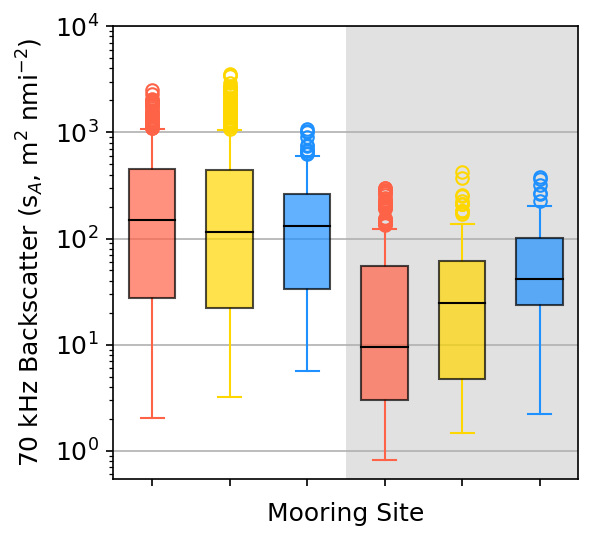

In [10]:
from scipy.stats import ttest_ind
fig = plt.figure(figsize=(4,4),dpi=150)
dfs = [dfD1,dfD2,dfD3]
noIce,yesIce = [],[]
p = [[1,2.5],[1.5,3],[2,3.5]]
ct = 0
cs = ['tomato','gold','dodgerblue']
iceCutoff = 20

plt.rcParams.update({'font.size':12})

for df in dfs:
    col = cs[ct]
    a = df['sA'].resample('2H').sum()
    b = a.resample('D').mean()
    df = dfD1Ice
    a = df.resample('D').mean()
    c = a.join(b)
    box = plt.boxplot(c[(c.iceC*100<iceCutoff)&(~c.sA.isnull())].sA,positions=[p[ct][0]],widths=.3,patch_artist=True)
    for item in ['whiskers','caps']:
        plt.setp(box[item], color=col)
    for item in ['medians','boxes']:
        plt.setp(box[item], color='k')
    plt.setp(box["fliers"], markeredgecolor=col)
    plt.setp(box["boxes"], facecolor=col,alpha=0.7)
    box = plt.boxplot(c[(c.iceC*100>=iceCutoff)&(~c.sA.isnull())].sA,positions=[p[ct][1]],widths=.3,patch_artist=True)
    for item in ['whiskers','caps']:
        plt.setp(box[item], color=col)
    for item in ['medians','boxes']:
        plt.setp(box[item], color='k')
    plt.setp(box["fliers"], markeredgecolor=col)
    plt.setp(box["boxes"], facecolor=col,alpha=0.7)
    ct+=1
    print(ttest_ind(c[(c.iceC*100<20)&(~c.sA.isnull())].sA, c[(c.iceC*100>20)&(~c.sA.isnull())].sA))
plt.yscale('log')
plt.xticks([1, 1.5, 2, 2.5,3,3.5], ['', '', '','','',''])
plt.axis([0.75,3.75,0,10**4])

from matplotlib.patches import Rectangle
rect =Rectangle((2.25,0),1.5,10**4,edgecolor='None',facecolor="dimgray", alpha=0.2)
plt.gca().add_patch(rect)
plt.ylabel('70 kHz Backscatter (s$_{A}$, m$^{2}$ nmi$^{-2}$)')
plt.xlabel('Mooring Site')
plt.grid(axis='y')

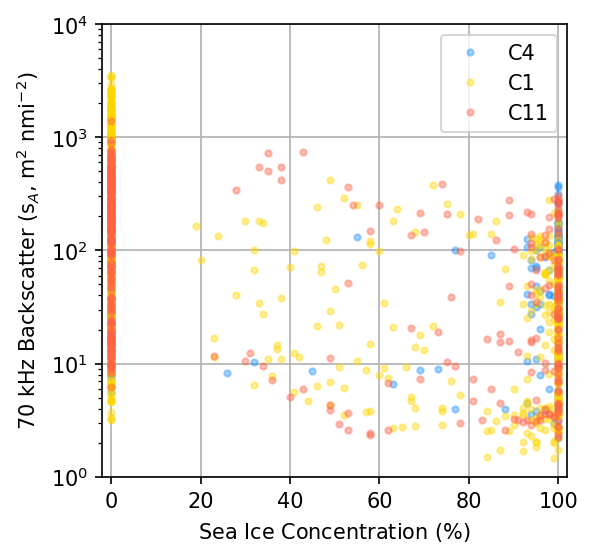

In [5]:
fig = plt.figure(figsize=(4,4),dpi=150)
df = dfD3
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD1Ice
a = df.resample('D').mean()
c = a.join(b)
plt.semilogy(c.iceC*100,c.sA,'.',color='dodgerblue',alpha=0.4)


df = dfD2
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD2Ice
a = df.resample('D').mean()
c = a.join(b)
plt.semilogy(c.iceC*100,(c.sA),'.',color='gold',alpha=0.4)


df = dfD1
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD3Ice
a = df.resample('D').mean()
c = a.join(b)
plt.semilogy(c.iceC*100,(c.sA),'.',color='tomato',alpha=0.4)

plt.axis([-2,102,0,10**4])
plt.grid()
plt.xlabel('Sea Ice Concentration ($\%$)')
plt.ylabel('70 kHz Backscatter (s$_{A}$, m$^{2}$ nmi$^{-2}$)')
plt.legend(['C4','C1','C11'],loc='upper right')

In [5]:
def bigFig(df,dfT,dfDayNight,dfSunlight,dfIce, dfCtd,col):  
    plt.rcParams.update({'font.size':16})
    pltDict = {'D1':[0,0,5000],'D2':[0,0,5000],'D3':[1,0,2000]}
    f, [ax1,ax2,ax3,ax4] = plt.subplots(4,1,figsize=(20,16),sharex=True, sharey=True,dpi=150)
    
    iceCov = iceDates(dfIce)
    
    ax1=plt.subplot(411)
    dfIce.iceC = dfIce.iceC/dfIce.iceC.max()
    dfIce.iceC.plot(legend=False,axes=ax1,color='skyblue',linewidth=2,label='Sea Ice')
    ax1_2 = dfCtd.Temp.plot(ax=ax1,secondary_y=True,color='grey',linewidth=2, label = 'Temperature')
    if pltDict[df.name][0]==1:
        ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-100, ymax=100, alpha=0.3, color='grey')
    ax1.set_ylim([0,1])
    ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-6')])
    ax1.grid()
    ax1.set_ylabel('Sea Ice\nCover (%)')
    ax1_2.set_ylabel('Temperature ($^{o}$C)')
    ax1_2.set_yticks([-2,0,2,4,6])
    legend_elements = [Line2D([0], [0], color='skyblue', lw=4, label='Sea Ice'),Line2D([0], [0], color='grey', lw=4, label='Temperature')]
    ax1_2.legend(handles=legend_elements,loc='upper right')
    plt.subplots_adjust(hspace=.2)    

    ax2=plt.subplot(412)
    a = df['sA'].resample('2H').sum()
    a.plot( style='.',label='Wakeups',legend=False,axes=ax2, color=col)
    a.rolling('7D').mean().plot(legend=False,label='Running 7-Day Mean', axes=ax2,linewidth=2,color='k')
    if pltDict[df.name][0]==1:
        ax2.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
    for a in iceCov:
        ax2.axvspan(pd.to_datetime(a[0]), pd.to_datetime(a[1]), ymin=-60, ymax=pltDict[df.name][2], alpha=0.3, color='skyblue')
    ax2.set_ylim([-60,pltDict[df.name][2]])
    #ax1.set_yticks([0,1000,2000,3000])
    ax2.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-6')])
    ax2.grid()
    ax2.legend(['Wakeup Mean','Running 7-Day Mean'],loc = 'upper right')
    ax2.set_xticklabels([])
    ax2.xaxis.label.set_visible(False)
    plt.ylabel('70 kHz Backscatter\n(s$_{A}$, m$^{2}$ nmi$^{-2}$)')
    
    ax3=plt.subplot(413)
    dfT['SigBS_mean'] = 10**(dfT.TS_mean/10)
    a = 10*np.log10(dfT.SigBS_mean.resample('H').mean())
    a.plot( style='.',label='Wakeups',legend=False,axes=ax3,color=col)
    a.rolling('7D').mean().plot(legend=False,label='Daily Mean', axes=ax3,linewidth=2,color='k')
    if pltDict[df.name][0]==1:
        ax3.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-100, ymax=100, alpha=0.3, color='grey')
    ax3.set_ylim([-70,-35])
    ax3.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-6')])
    for a in iceCov:
        ax3.axvspan(pd.to_datetime(a[0]), pd.to_datetime(a[1]), ymin=-100, ymax=200, alpha=0.3, color='skyblue')
    ax3.grid()
    ax3.set_xticklabels([])
    ax3.xaxis.label.set_visible(False)
    plt.ylabel('70 kHz Target Strength\n(dB re 1 m$^{2}$)')
    plt.subplots_adjust(hspace=.2)
    
    ax4=plt.subplot(414)
    a = dfDayNight.night-dfDayNight.day
    ax4.plot(a.rolling('7D').mean(),'k',zorder=5)
    ax4.fill_between(a.rolling('7D').mean().index, a.rolling('7D').mean(), where=a.rolling('7D').mean()>=0, interpolate=True, color='grey',alpha=0.6,zorder=2)
    ax4.fill_between(a.rolling('7D').mean().index, a.rolling('7D').mean(), where=a.rolling('7D').mean()<=0, interpolate=True, color='grey',alpha=0.6,zorder=2)
    
    s = dfSunlight.s*24
    ax4_2 = s.plot(ax=ax4,secondary_y=True,color='darkgoldenrod',zorder=0)
    ax4_2.set_ylim([0,24])
    
    #plt.hlines(0,pd.to_datetime('2017-8-4'),pd.to_datetime('2019-9-4'),'k')
    if pltDict[df.name][0]==1:
        ax4.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-40, ymax=30, alpha=0.3, color='grey')
    for a in iceCov:
        ax4.axvspan(pd.to_datetime(a[0]), pd.to_datetime(a[1]), ymin=-25, ymax=15, alpha=0.3, color='skyblue',zorder=3)
    ax4.set_ylim([-25,25])
    ax4.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-6')])
    ax4.grid(zorder=4)
    #ax4.legend(['Running 7-Day Mean'],loc = 'upper right')
    #legend_1 = ax4.legend(['Running 7-Day Mean'],loc = 'upper right', borderaxespad=1.)
    #legend_1.remove()
    legend_elements = [Line2D([0], [0], color='k', lw=4, label='Running 7-Day Mean'),Line2D([0], [0], color='darkgoldenrod', lw=4, label='Daylight')]
    ax4_2.legend(handles=legend_elements,loc='upper right')
    #ax4_2.legend(loc=1, borderaxespad=1.)
    #ax4.set_xticklabels([])
    #ax4.xaxis.label.set_visible(False)
    ax4.set_ylabel('Night - Day Difference in \n Weighted Mean Depth (m)')
    ax4_2.set_ylabel('Hours of daylight')
    maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,3))
    ax4.xaxis.set_major_locator(maj_loc)
    min_loc = mdates.MonthLocator()
    ax4.xaxis.set_minor_locator(min_loc)
    zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
    maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
    ax4.xaxis.set_major_formatter(maj_fmt)
    ax4.set_xlabel('Date')
    

def iceDates(df):
    df['o20']= 0
    df['o20'][(df.iceC > .2)] = 1
    df['shift'] = df['o20'].diff()
    dfShift = df[(df['shift'] != 0)&(~df['shift'].isnull())]
    dates = dfShift.index.values
    iceD = np.array(dates).reshape(int(len(dates)/2),2)
    return iceD

In [68]:
c = pd.merge_asof(left=dfD1_DayNight,right=dfD1_sunlight,right_index=True,left_index=True,direction='nearest')
d = dfD1T.resample('1D').mean()[['TS_mean']]
c['nightDay'] = c.night-c.day
d = dfD1T.resample('1D').mean()[['TS_mean']]
e1 = pd.merge_asof(left=c,right=d,right_index=True,left_index=True,direction='nearest')

c = pd.merge_asof(left=dfD2_DayNight,right=dfD2_sunlight,right_index=True,left_index=True,direction='nearest')
d = dfD1T.resample('1D').mean()[['TS_mean']]
c['nightDay'] = c.night-c.day
d = dfD1T.resample('1D').mean()[['TS_mean']]
e2 = pd.merge_asof(left=c,right=d,right_index=True,left_index=True,direction='nearest')

c = pd.merge_asof(left=dfD3_DayNight,right=dfD3_sunlight,right_index=True,left_index=True,direction='nearest')
d = dfD1T.resample('1D').mean()[['TS_mean']]
c['nightDay'] = c.night-c.day
d = dfD1T.resample('1D').mean()[['TS_mean']]
e3 = pd.merge_asof(left=c,right=d,right_index=True,left_index=True,direction='nearest')

eAll = pd.concat([e1,e2,e3])

Text(0, 0.5, 'Night - day difference in \n weighted mean depth (m)')

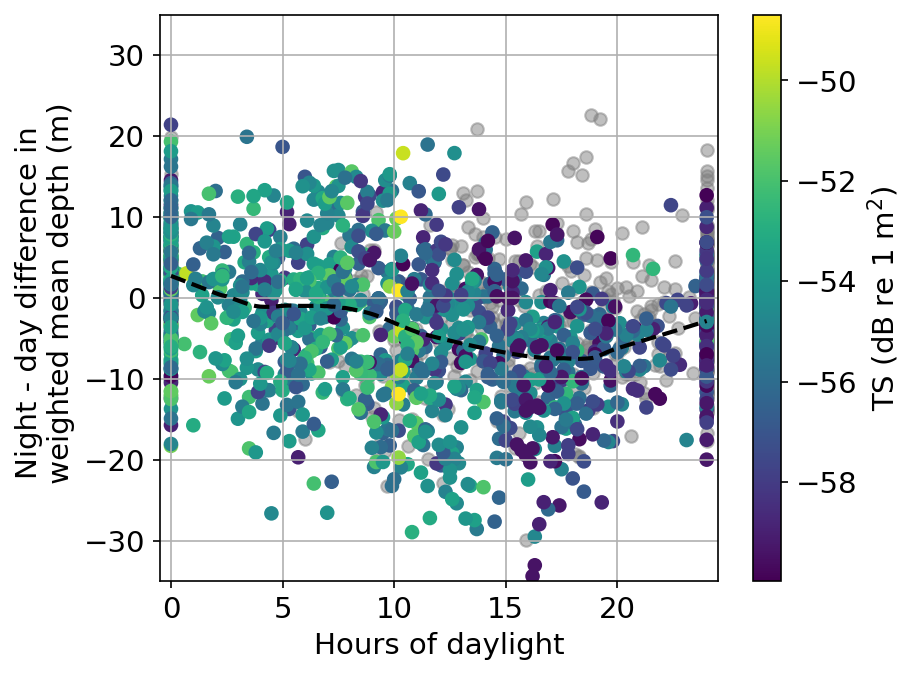

In [65]:
fig = plt.figure(figsize=(6,5),dpi=150)

e = pd.concat([e1,e2,e3])
e['s'] = e.s*24
e = e[e.TS_mean<-60]
plt.scatter(e.s,e.nightDay,c='grey',alpha=0.5)

e = pd.concat([e1,e2,e3])
e['s'] = e.s*24
e = e[e.TS_mean>-60]
plt.scatter(e.s,e.nightDay,c=e.TS_mean)

from statsmodels.nonparametric.smoothers_lowess import lowess
filtered = lowess(e.nightDay,e.s, frac=.333)
plt.plot(filtered[:,0], filtered[:,1],linestyle='--',color='k', lw=2,label='_nolegend_',zorder=10)

plt.grid()
plt.axis([-.5,24.5,-35,35])
plt.colorbar(label='TS (dB re 1 m$^{2}$)')
plt.xlabel('Hours of daylight')
plt.ylabel('Night - day difference in \n weighted mean depth (m)')

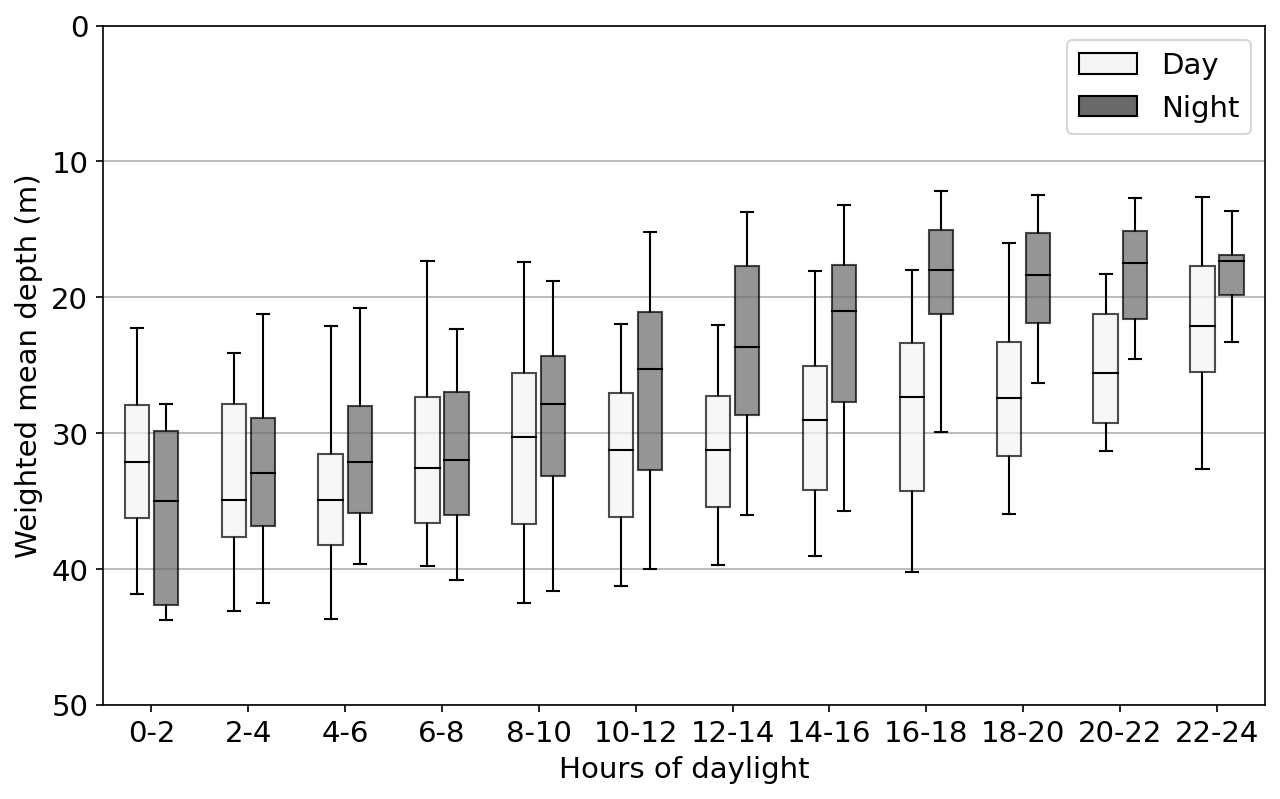

In [71]:
cutoff = -60
e = pd.concat([e1,e2,e3])
e['s'] = e.s*24
e = e[e.TS_mean>cutoff]
n = []
for h in np.arange(0,24,2):
    n.append(e[(e.s>=h)&(e.s<=h+2)].day.values)

e = pd.concat([e1,e2,e3])
e['s'] = e.s*24
e = e[e.TS_mean>cutoff]
z = []
for h in np.arange(0,24,2):
    if len(e[(e.s>=h)&(e.s<=h+2)].night.values) ==0:
        z.append([])
    else:
        z.append(e[(e.s>=h)&(e.s<=h+2)&(e.s!=0)&(e.s!=24)].night.values)


plt.figure(figsize=(10,6),dpi=150)
plt.rcParams.update({'font.size':14})
col='whitesmoke'
box = plt.boxplot(n,positions = np.arange(0,12,1)-.15,widths=.25,patch_artist=True,whis=[5, 95],showfliers=False);
for item in ['whiskers','caps']:
    plt.setp(box[item], color='k')
for item in ['medians','boxes']:
    plt.setp(box[item], color='k')
plt.setp(box["fliers"], markeredgecolor=col)
plt.setp(box["boxes"], facecolor=col,alpha=0.7)
plt.xticks([]);
    
col='dimgrey'
box = plt.boxplot(z,positions = np.arange(0,12,1)+.15,widths=.25,patch_artist=True,whis=[5, 95],showfliers=False);
for item in ['whiskers','caps']:
    plt.setp(box[item], color='k')
for item in ['medians','boxes']:
    plt.setp(box[item], color='k')
plt.setp(box["fliers"], markeredgecolor='k')
plt.setp(box["boxes"], facecolor=col,alpha=0.7)

plt.axis([-0.5,11.5,0,50])
plt.gca().invert_yaxis()
#plt.grid()
plt.xticks(np.arange(0,12,1),[str(n)+'-'+str(n+2) for n in np.arange(0,24,2)])
plt.grid(axis='y')
plt.xlabel('Hours of daylight')
plt.ylabel('Weighted mean depth (m)')


from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor='whitesmoke', edgecolor='k',label='Day'),
                   Patch(facecolor='dimgrey', edgecolor='k',label='Night')]

plt.legend(handles=legend_elements)

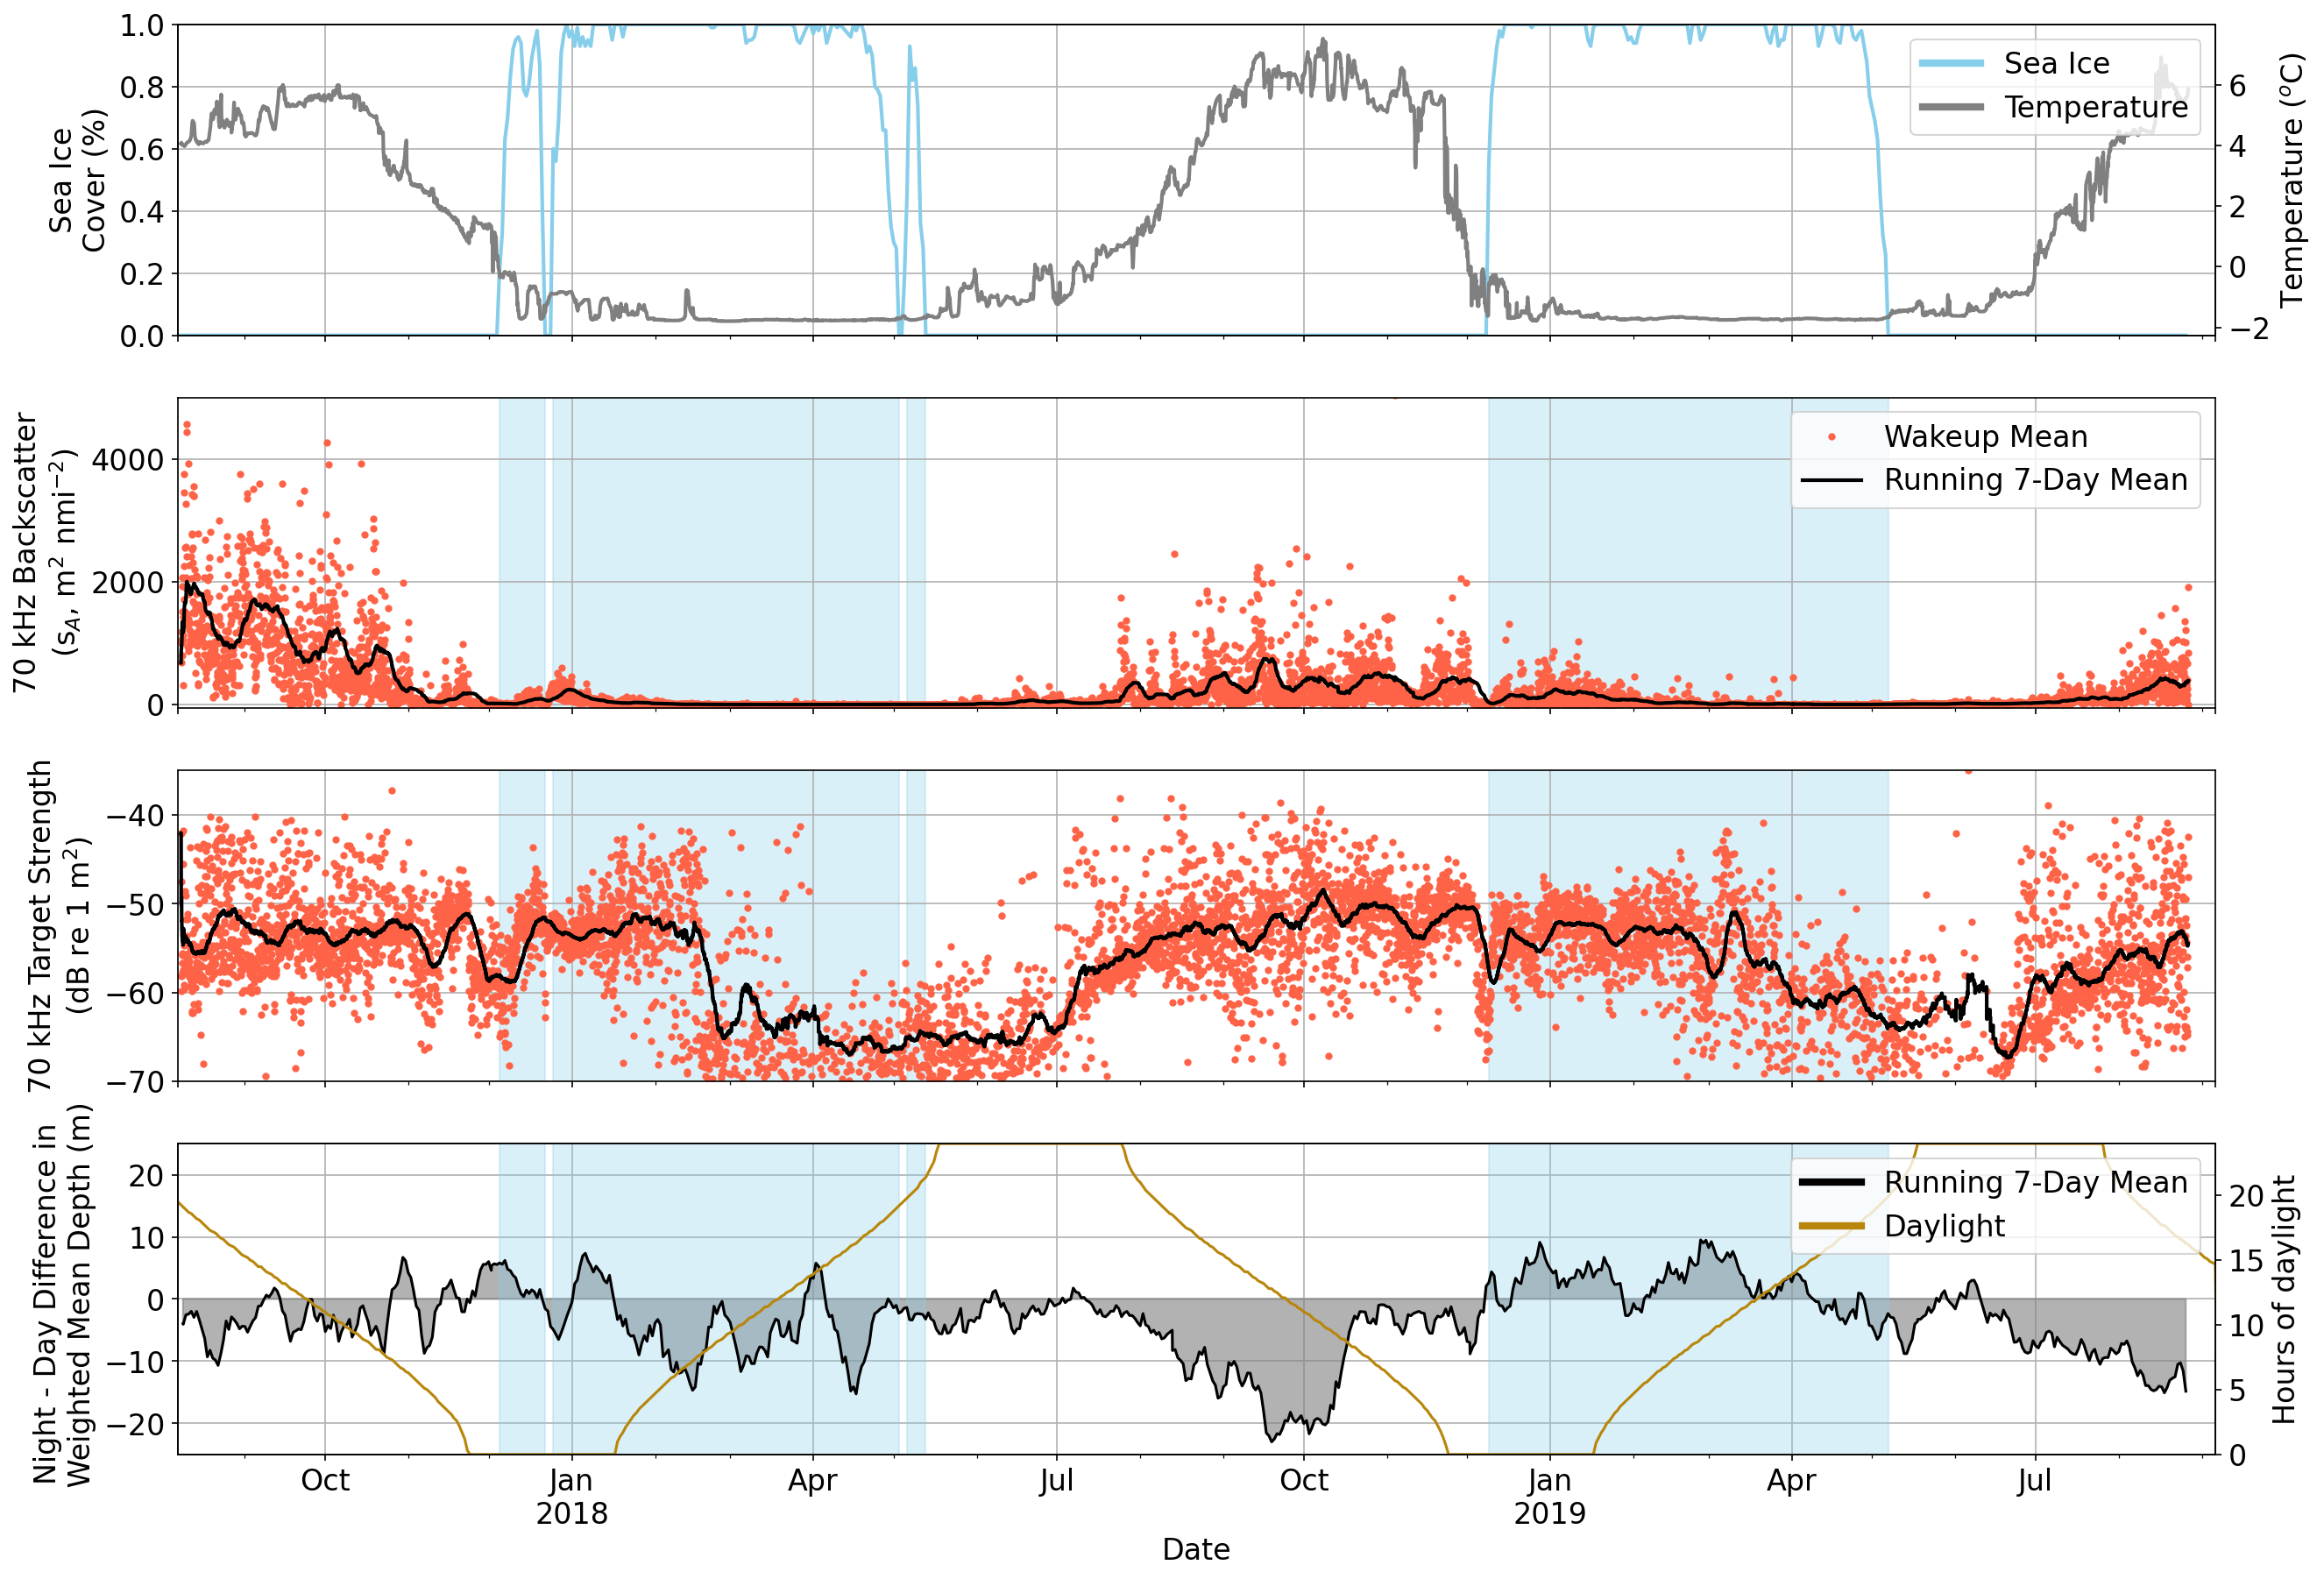

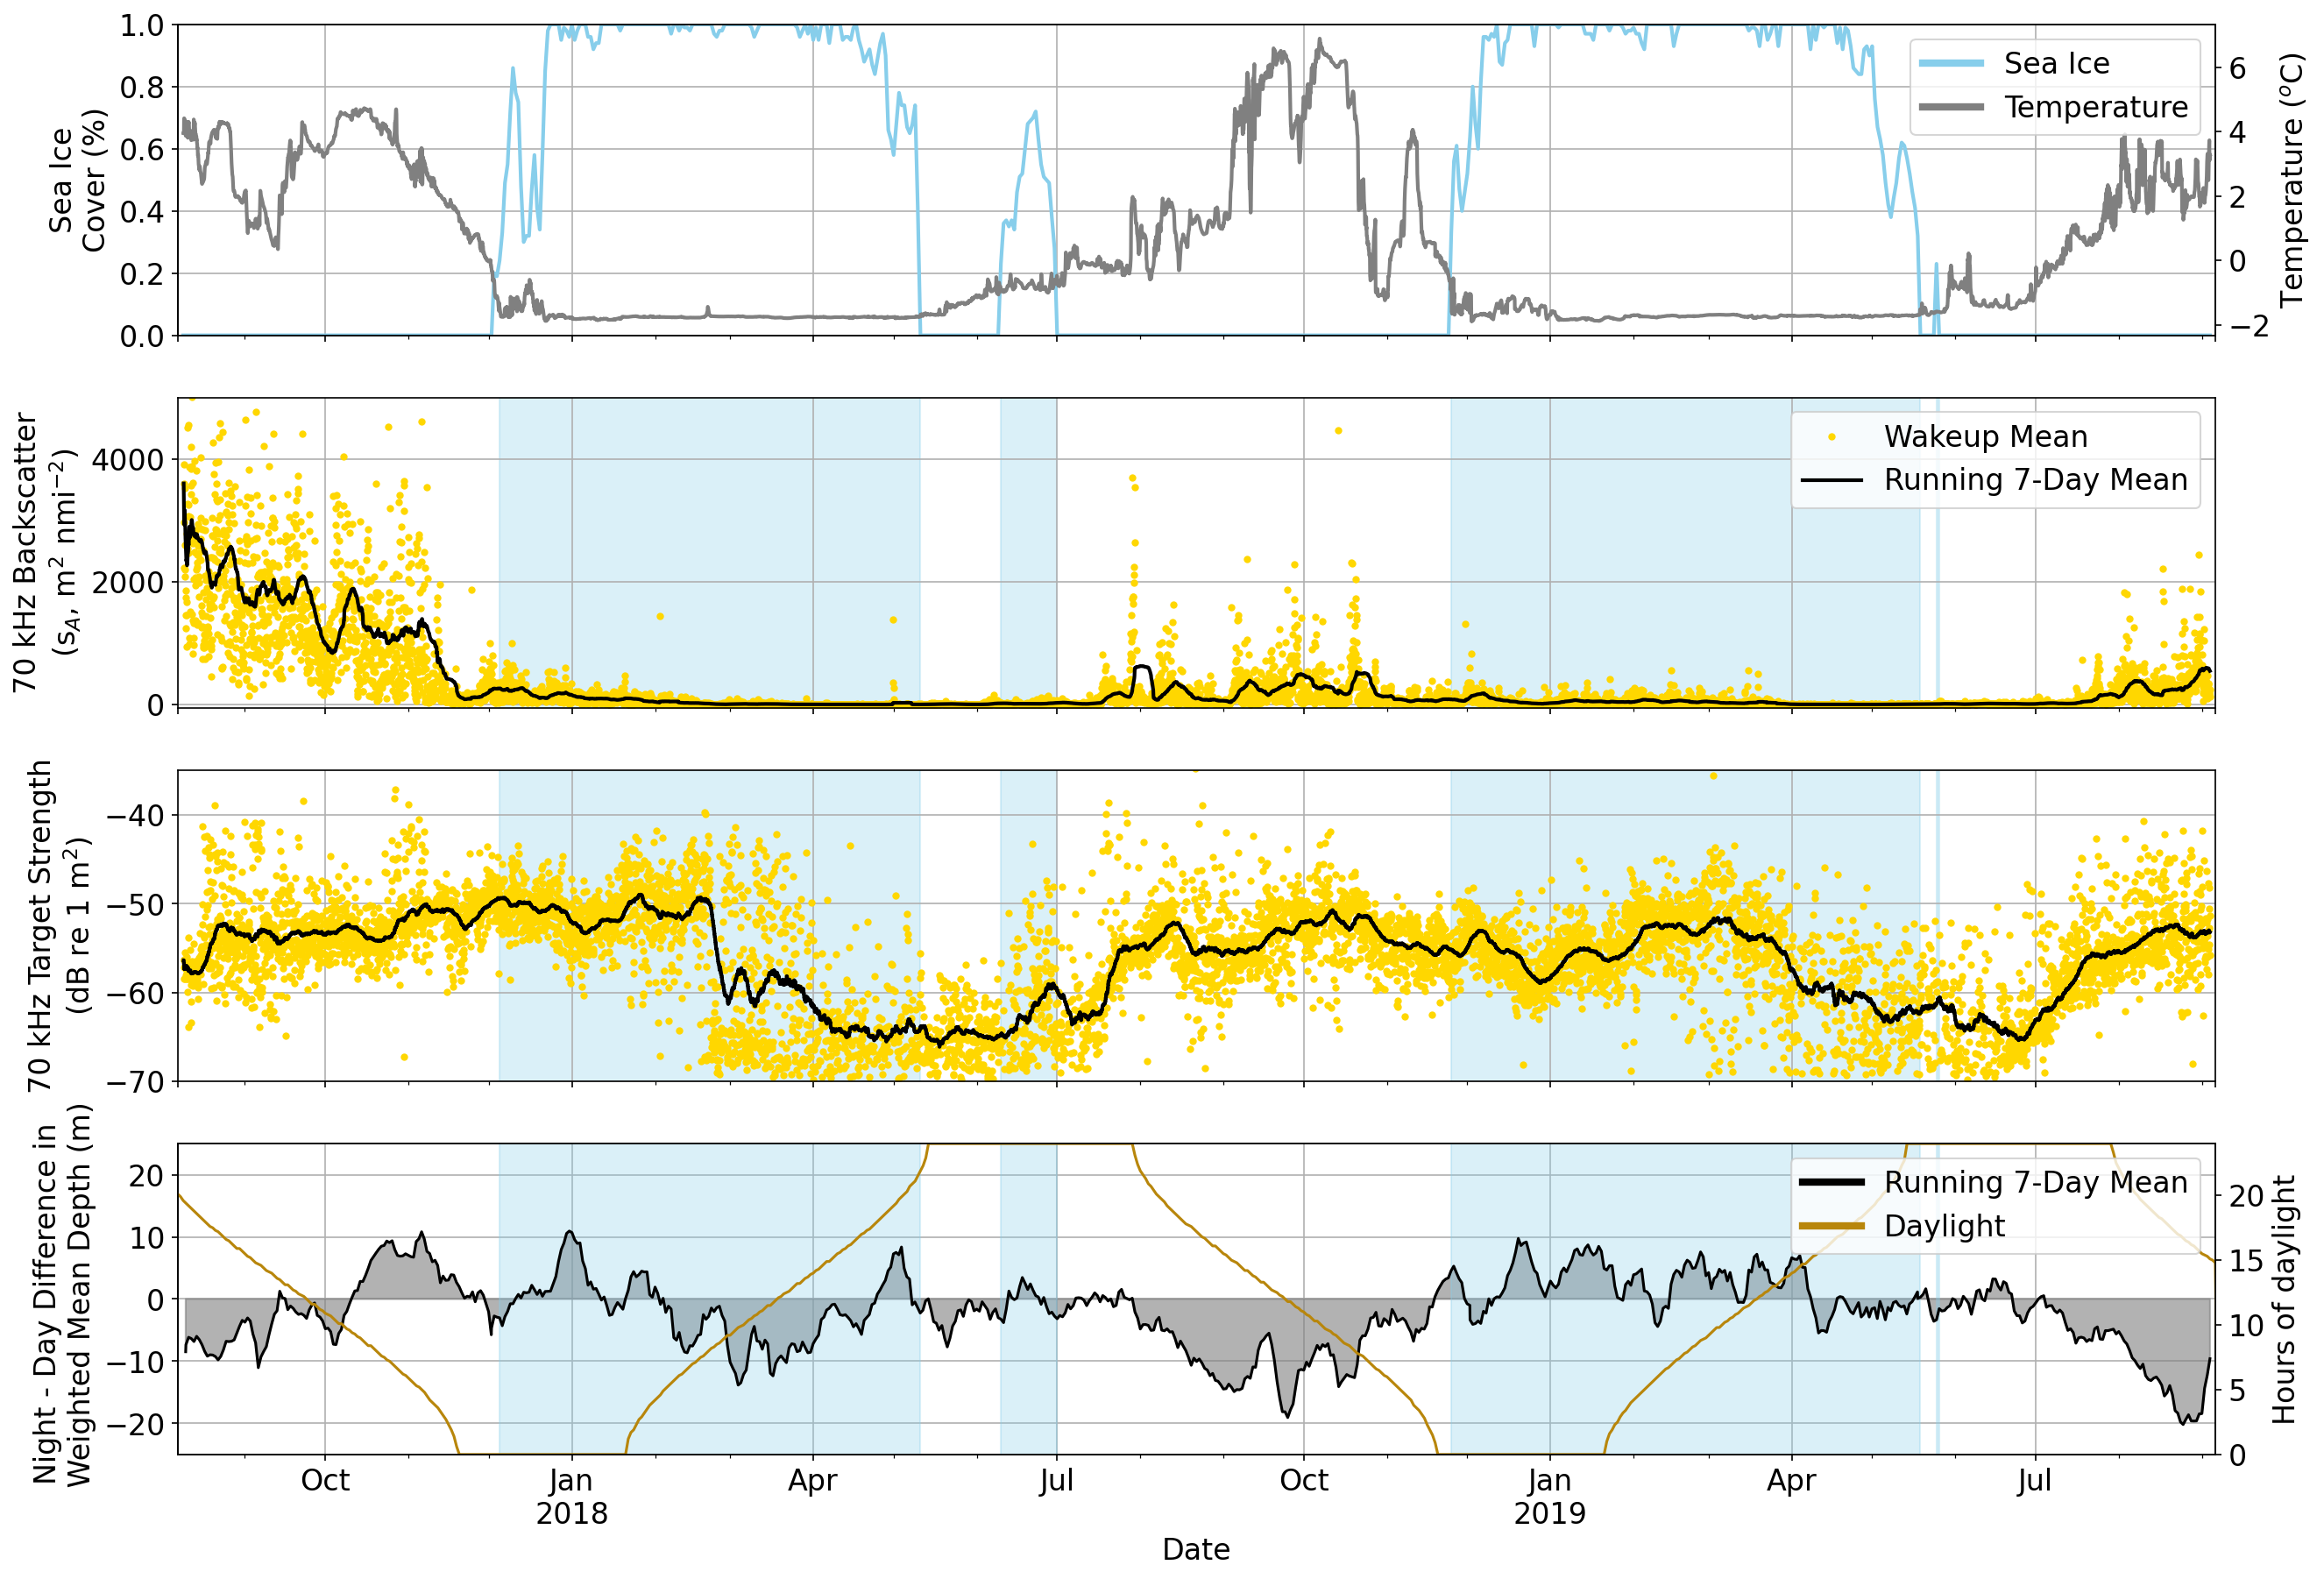

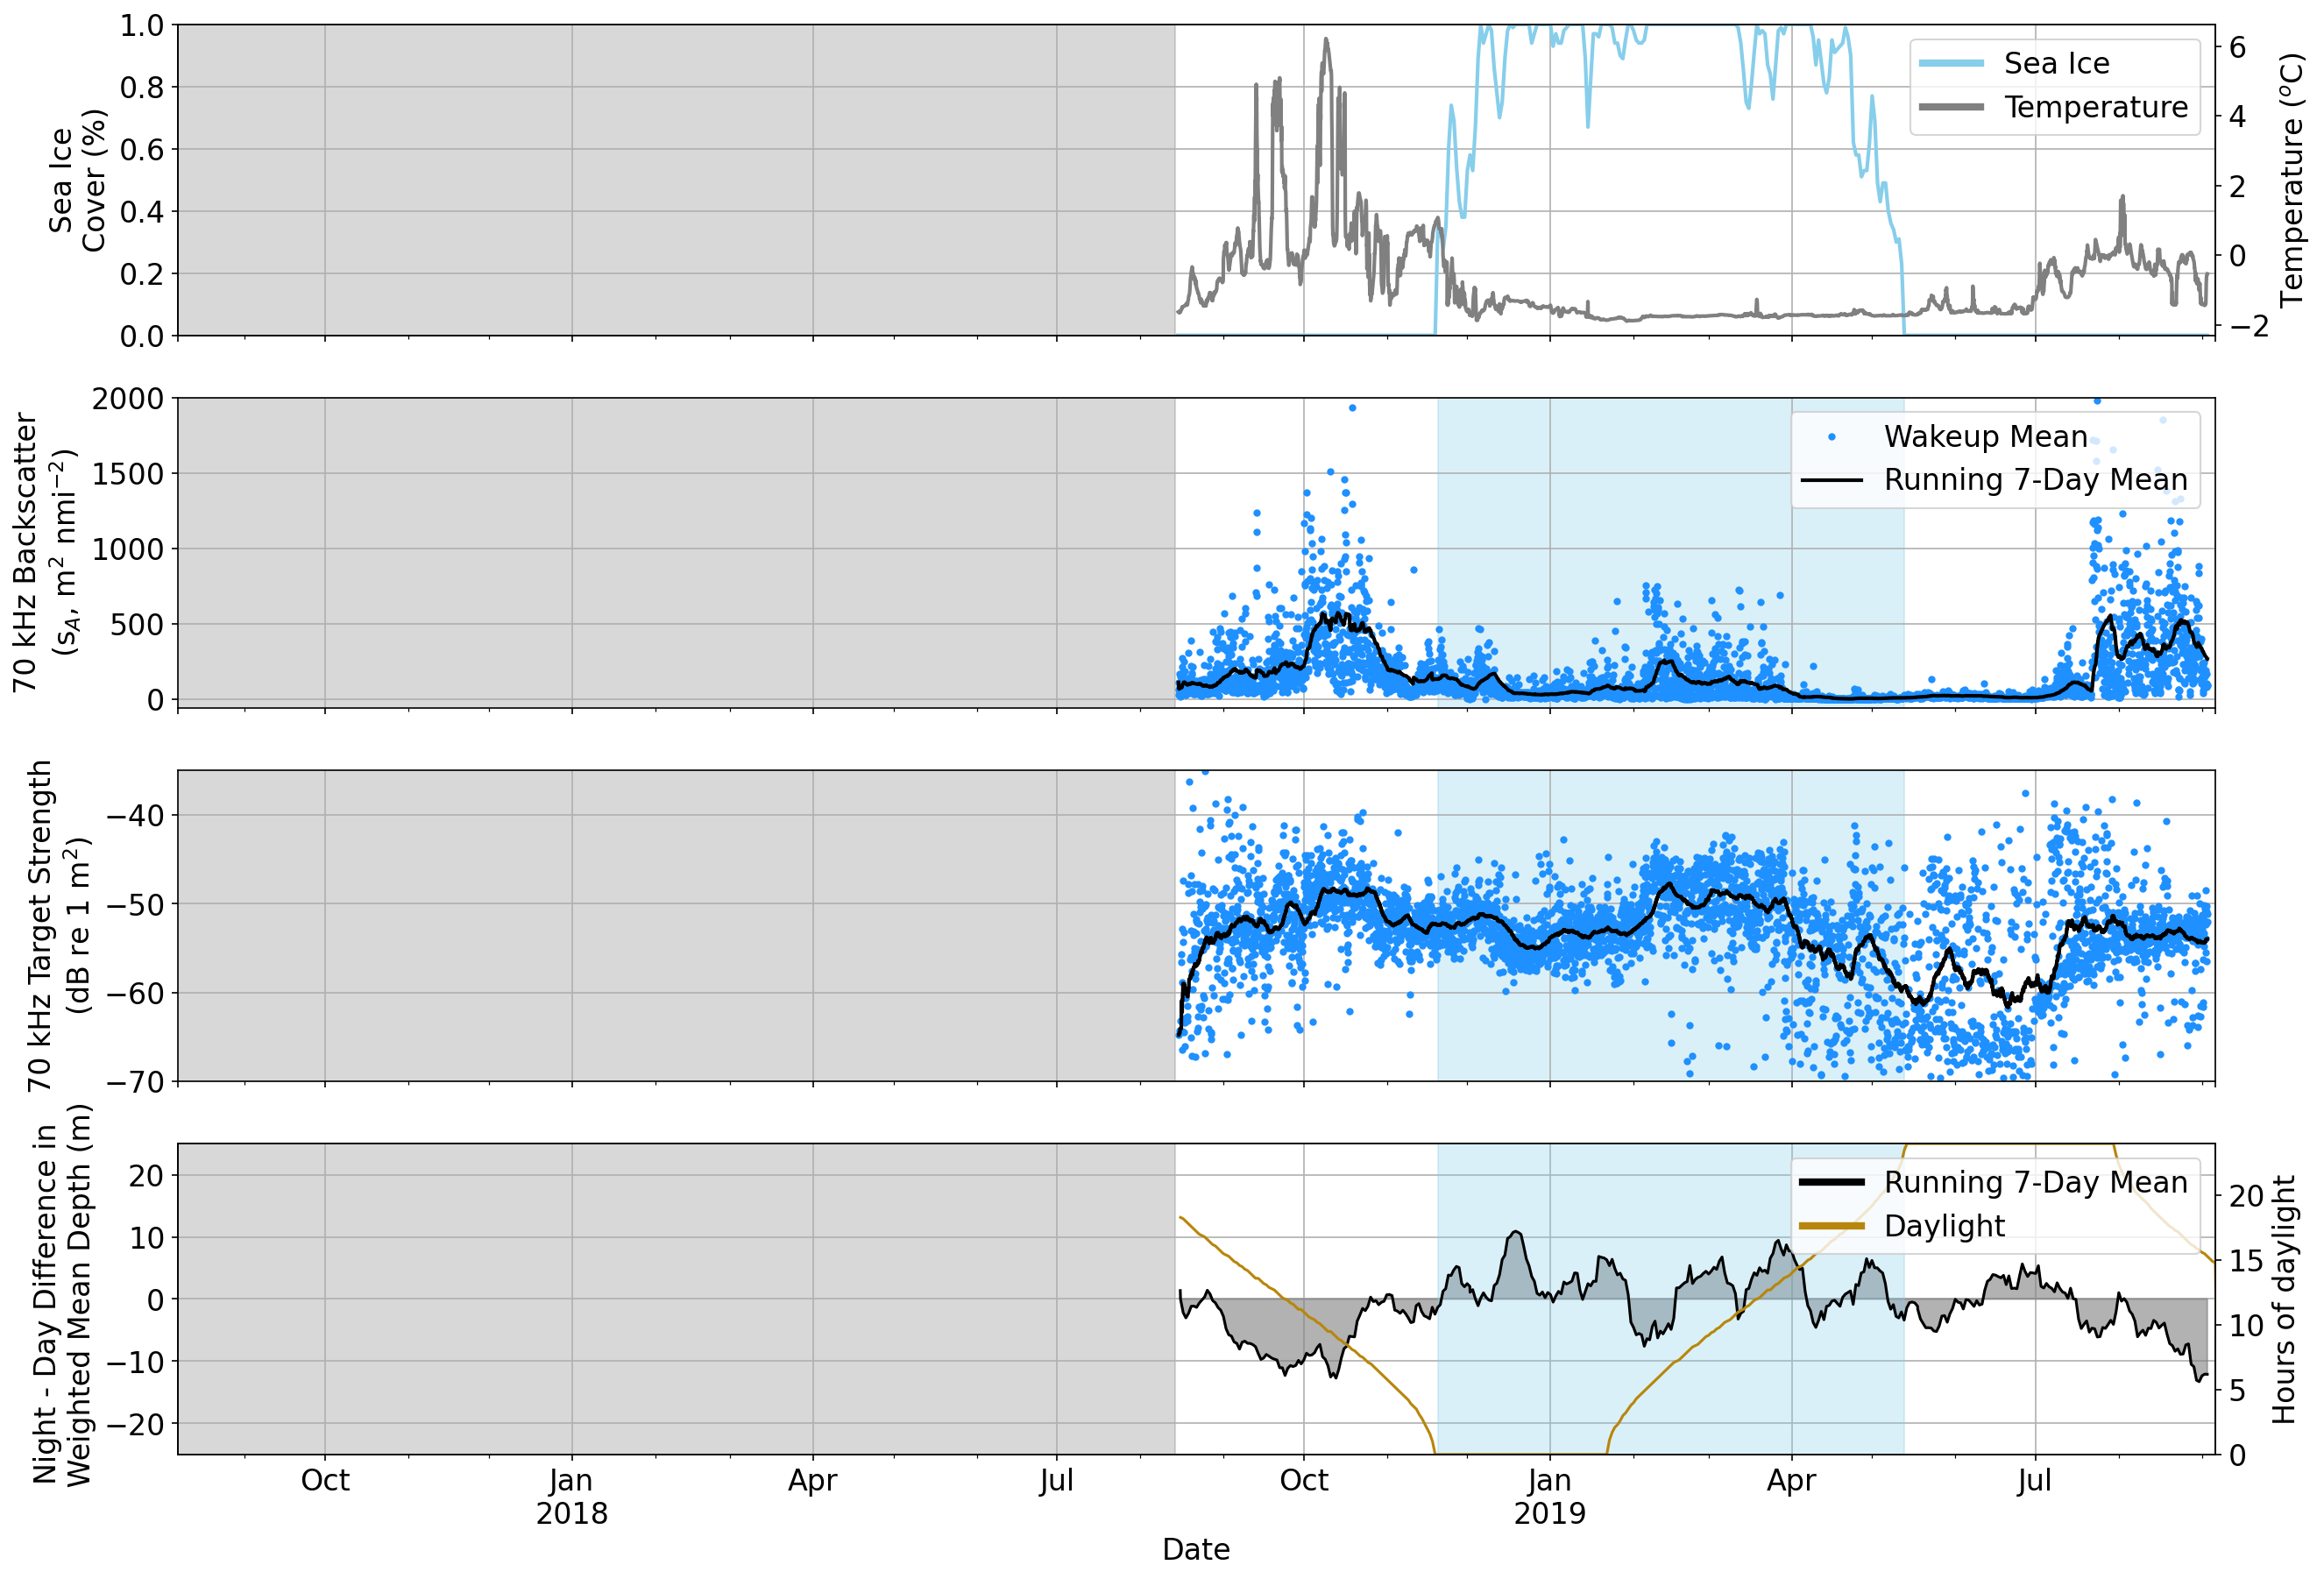

In [24]:
bigFig(dfD1,dfD1T,dfD1_DayNight,dfD1_sunlight,dfD1Ice,dfD1Ctd,'tomato')
bigFig(dfD2,dfD2T,dfD2_DayNight,dfD2_sunlight,dfD2Ice,dfD2Ctd,'gold')
bigFig(dfD3,dfD3T,dfD3_DayNight,dfD3_sunlight[dfD1_sunlight.index>'2018-08-15'],dfD3Ice,dfD3Ctd,'dodgerblue')